### notes

- partitioning of the dataset based on the variation
- typically applied to standardized data
- with standardized data, "variation" means "correlation"
- with unstandardized data, "variation" means "covariance"
- new features are called the "principal components" -> can be as many as features
- weights are themselves called "loadings"
- a component"s loadings tell us what variation it expresses through signs and magnitudes


### custom generated dataset

In [6]:
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

In [21]:
def plot_variance(pca, width=8, dpi=100):
    # create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    
    # explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # cumulative variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [8]:
n_samples = 10000
n_features = 2

# generate data
data, labels = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    cluster_std=0.9,
    shuffle=True,
    centers=4,
    # centers=[(3, 3), (7, 7)],
    # center_box=(0, 1),
)
print(f"data: {data.shape}, labels: {labels.shape}")

# visualize
cols = [f"col_{i}" for i in range(n_features)]
df = pd.DataFrame(data, columns=cols)
fig = px.scatter(df, x="col_0", y="col_1")
fig.show()

data: (10000, 2), labels: (10000,)


In [9]:
# apply pca
pca = PCA()

reduced_data = pca.fit_transform(data)
print(f"reduced_data.shape: {reduced_data.shape}")

# visualize
n_components = reduced_data.shape[1]
cols = [f"pc_{i}" for i in range(n_components)]
df = pd.DataFrame(reduced_data, columns=cols)
fig = px.scatter(df, x="pc_0", y="pc_1")
fig.show()

reduced_data.shape: (10000, 2)


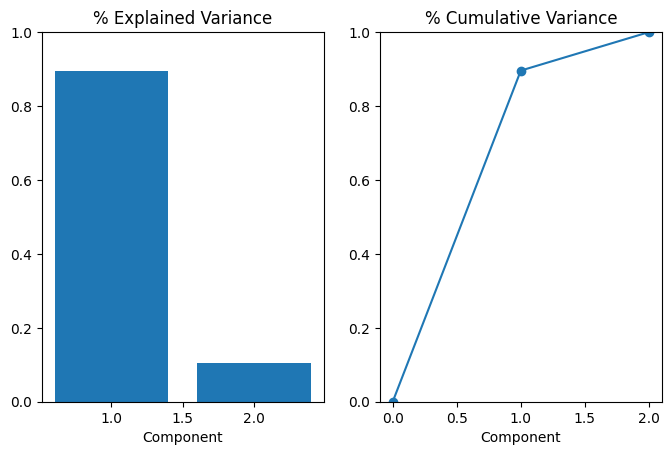

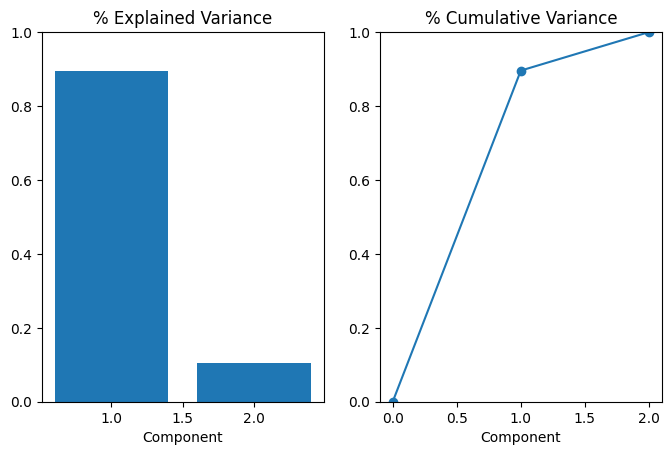

In [10]:
plot_variance(pca)

In [11]:
from sklearn.preprocessing import normalize

n_samples = 10000
n_features = 4
n_components = 2

# generate data
data = np.random.rand(n_samples, n_features)
labels = np.random.rand(0, 2, n_features)
print(f"data.shape: {data.shape} | labels.shape: {labels.shape}")

data_norm = normalize(data)
print(f"data_norm.shape: {data_norm.shape}")

# visualize
cols = [f"col_{i}" for i in range(n_features)]
df = pd.DataFrame(data_norm, columns=cols)
fig = px.scatter(df, x="col_0", y="col_1")
fig.show()

data.shape: (10000, 4) | labels.shape: (0, 2, 4)
data_norm.shape: (10000, 4)


In [12]:
# apply pca
pca = PCA(n_components=n_components)
# reduced_data = pca.fit_transform(data)
reduced_data = pca.fit_transform(data_norm)
print(f"reduced_data.shape: {reduced_data.shape}")

# visualize
n_components = reduced_data.shape[1]
cols = [f"pc_{i}" for i in range(n_components)]
df = pd.DataFrame(reduced_data, columns=cols)
fig = px.scatter(df, x="pc_0", y="pc_1")
fig.show()

reduced_data.shape: (10000, 2)


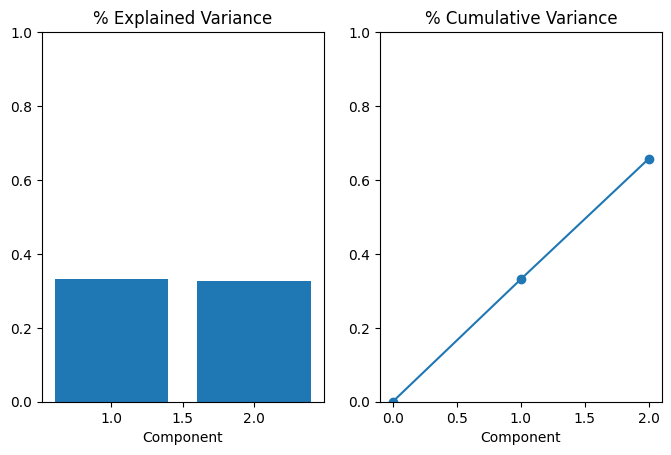

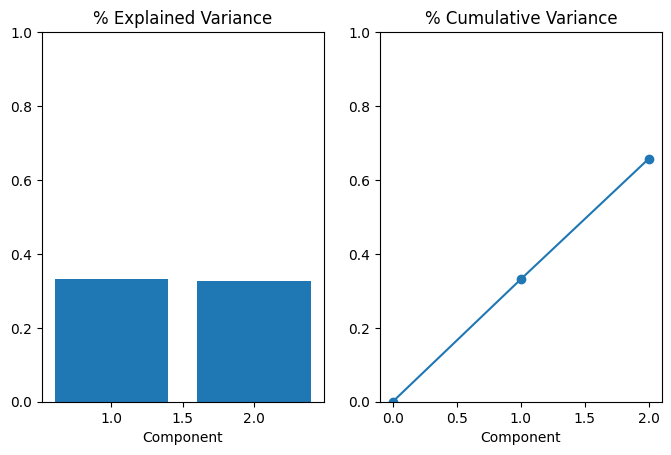

In [13]:
plot_variance(pca)

### kaggle dataset

In [22]:
import numpy as np
import pandas as pd

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.model_selection import (
    train_test_split, StratifiedKFold
)
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, f1_score,
    accuracy_score, roc_auc_score,
)
import warnings
warnings.filterwarnings("ignore")

In [23]:
def plot_variance(pca, width=8, dpi=100):
    # create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    
    # explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    
    # cumulative variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [24]:
# data source: https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data
def get_prep_data():
    # read data
    df = pd.read_csv("dataset/breast-cancer-wisconsin.csv")
    
    # drop columns
    df.drop(["id", "Unnamed: 32"], axis=1, inplace=True)
    
    # encode target variable
    df["diagnosis"] = df["diagnosis"].map({"B": 0, "M": 1})
    
    # sample  
    holdout_ids = df.sample(frac=0.1, random_state=66).index
    
    # split
    train = (
        df.loc[~df.index.isin(holdout_ids)]
        .sample(frac=1, random_state=66)
        .sort_values("diagnosis")
        .reset_index(drop=True)
    )
    holdout = (
        df.loc[df.index.isin(holdout_ids)]
        .sample(frac=1, random_state=529)
        .sort_values("diagnosis")
        .reset_index(drop=True)
    )

    return train, holdout

In [25]:
train, holdout = get_prep_data()

print(f"train.shape: {train.shape}")
print(f"holdout.shape: {holdout.shape}")

train.head()

train.shape: (512, 31)
holdout.shape: (57, 31)


diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          0        14.05         27.15           91.38      600.4   
1          0        12.18         17.84           77.79      451.1   
2          0        12.98         19.35           84.52      514.0   
3          0        12.87         19.54           82.67      509.2   
4          0        12.96         18.29           84.18      525.2   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.09929           0.11260         0.04462              0.04304   
1          0.10450           0.07057         0.02490              0.02941   
2          0.09579           0.11250         0.07107              0.02950   
3          0.09136           0.07883         0.01797              0.02090   
4          0.07351           0.07899         0.04057              0.01883   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.1537  ...         15.30          33.17           100.20   
1         0.1900  ...         12.83          20.92            82.14   
2         0.1761  ...         14.42          21.95            99.21   
3         0.1861  ...         14.45          24.38            95.14   
4         0.1874  ...         14.13          24.61            96.31   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0       706.7           0.12410            0.22640          0.13260   
1       495.2           0.11400            0.09358          0.04980   
2       634.3           0.12880            0.32530          0.34390   
3       626.9           0.12140            0.16520          0.07127   
4       621.9           0.09329            0.23180          0.16040   

   concave points_worst  symmetry_worst  fractal_dimension_worst  
0               0.10480          0.2250                  0.08321  
1               0.05882          0.2227                  0.07376  
2               0.09858          0.3596                  0.09166  
3               0.06384          0.3313                  0.07735  
4               0.06608          0.3207                  0.07247  

[5 rows x 31 columns]

In [26]:
fig = px.bar(train["diagnosis"].value_counts())
fig.show()

In [21]:
# standardize train data
train_labels = train["diagnosis"]

train_features = train.drop("diagnosis", axis=1)
train_features = (train_features - train_features.mean()) / train_features.std()

train_norm = pd.concat([train_labels, train_features], axis = 1)

train_norm.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          0     0.004085      1.781300        0.001662  -0.132898   
1          0    -0.533733     -0.351603       -0.564917  -0.567769   
2          0    -0.303650     -0.005665       -0.284337  -0.384558   
3          0    -0.335287      0.037864       -0.361465  -0.398539   
4          0    -0.309402     -0.248509       -0.298512  -0.351935   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0         0.210718          0.171112       -0.542009            -0.131003   
1         0.581572         -0.624926       -0.794021            -0.487269   
2        -0.038417          0.169218       -0.203990            -0.484916   
3        -0.353750         -0.468483       -0.882584            -0.709706   
4        -1.624337         -0.465453       -0.593766            -0.763813   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0      -1.004246  ...     -0.180783       1.180371        -0.188992   
1       0.322923  ...     -0.692273      -0.783928        -0.728235   
2      -0.185276  ...     -0.363014      -0.618767        -0.218552   
3       0.180335  ...     -0.356802      -0.229114        -0.340076   
4       0.227864  ...     -0.423067      -0.192233        -0.305142   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0   -0.288706         -0.363054          -0.163547        -0.651761   
1   -0.660079         -0.805235          -1.002291        -1.047987   
2   -0.415833         -0.157287           0.460996         0.359382   
3   -0.428827         -0.481261          -0.550018        -0.945246   
4   -0.437606         -1.711926          -0.129447        -0.518728   

   concave points_worst  symmetry_worst  fractal_dimension_worst  
0             -0.127572       -1.072249                -0.039690  
1             -0.828263       -1.110232                -0.555744  
2             -0.222359        1.150602                 0.421756  
3             -0.751763        0.683242                -0.359698  
4             -0.717628        0.508188                -0.626190  

[5 rows x 31 columns]

In [27]:
# standardize data
holdout_labels = holdout["diagnosis"]

houldout_features = holdout.drop("diagnosis", axis=1)
houldout_features = (houldout_features - houldout_features.mean()) / houldout_features.std()

holdout_norm = pd.concat([holdout_labels, houldout_features], axis = 1)

holdout_norm.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          0    -0.829302     -0.266588       -0.819635  -0.748274   
1          0    -0.108652      0.224926       -0.127052  -0.179621   
2          0     0.490161      0.258062        0.406720   0.349889   
3          0    -0.684135     -0.553765       -0.695151  -0.633007   
4          0    -1.150743      0.459638       -1.093122  -0.961279   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0         0.744480         -0.268048       -0.569070            -0.286409   
1        -0.890360         -0.629743       -0.181108            -0.638918   
2        -1.548624         -0.738838       -0.583557            -0.674751   
3        -0.343087         -0.813332       -0.778691            -0.790858   
4         1.086525          0.359104       -0.438030            -0.605645   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0      -0.755161  ...     -0.752604       0.674504        -0.740507   
1      -1.198111  ...     -0.172587       0.753860        -0.167705   
2       0.116566  ...      0.225138       0.691924         0.189199   
3      -0.322841  ...     -0.626243      -0.248729        -0.705694   
4       0.392967  ...     -1.237331      -0.337762        -1.205653   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0   -0.730345          0.119692          -0.584607        -0.810824   
1   -0.238717         -1.013022          -0.047485         0.367585   
2    0.117368         -1.934877          -0.681897        -0.558831   
3   -0.626436         -0.633999          -0.592039        -0.646247   
4   -1.044726         -0.093781          -0.452860        -0.845497   

   concave points_worst  symmetry_worst  fractal_dimension_worst  
0             -0.402005       -0.595442                -0.409349  
1             -0.478782       -0.605001                -0.595738  
2             -0.654489       -0.528528                -1.540997  
3             -0.620500       -0.404260                -0.503177  
4             -1.003475       -0.725172                 0.395168  

[5 rows x 31 columns]

<Axes: title={'center': 'Correlation Between Predictor Variables'}>

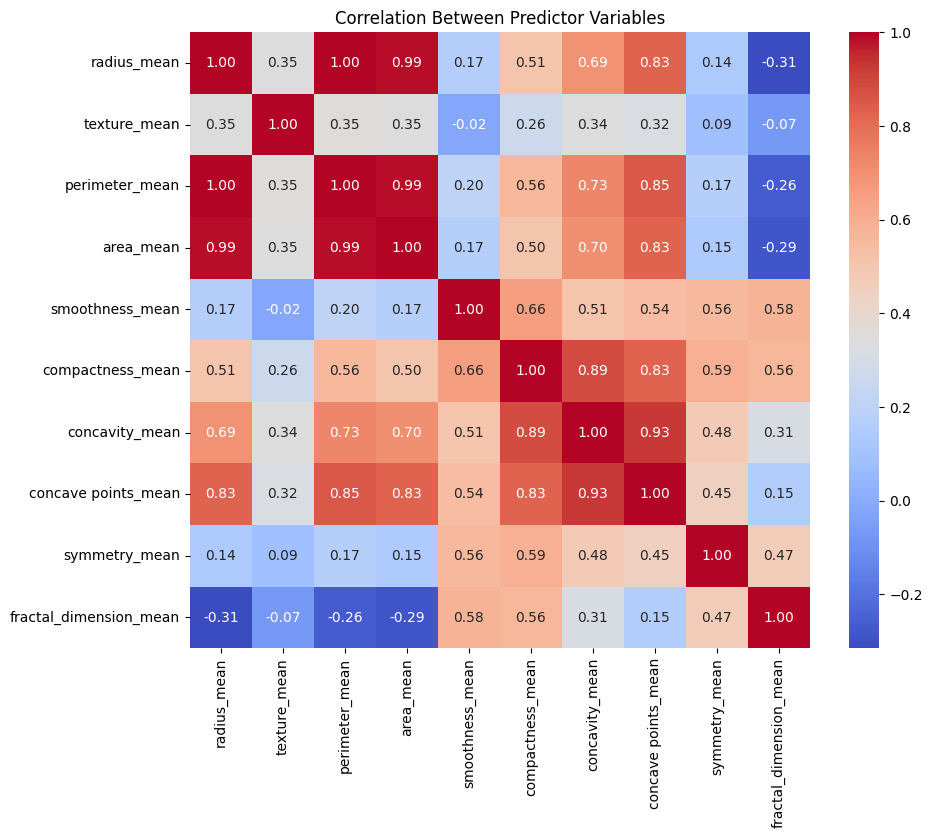

In [28]:
# plot correlation matrix
train_feature_mean = train_norm.iloc[:, 1:11]

correlation = train_feature_mean.corr()

plt.figure(figsize = (10, 8))
plt.title('Correlation Between Predictor Variables')

sns.heatmap(correlation, annot = True, fmt = '.2f', cmap = 'coolwarm')

# notice that radius, perimeter and area related columns are higly correlated (multi-collinearity)

### baseline

In [8]:
# get data
X, y = train.drop("diagnosis", axis=1), train["diagnosis"]
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.1)

print(f"X_tr.shape: {X_tr.shape} | y_tr.shape: {y_tr.shape}")
print(f"X_val.shape: {X_val.shape} | y_val.shape: {y_val.shape}")

X_tr.shape: (460, 30) | y_tr.shape: (460,)
X_val.shape: (52, 30) | y_val.shape: (52,)


In [9]:
# train
# clf = make_pipeline(StandardScaler(), lgb.LGBMClassifier(n_estimators=100, max_depth=3))
clf = make_pipeline(StandardScaler(), RandomForestClassifier(random_state = 42))

clf.fit(X_tr, y_tr)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

--- validation dataset ---
f1: 0.9642857142857143
accuracy: 0.9615
AUC: 0.9925


<Axes: >

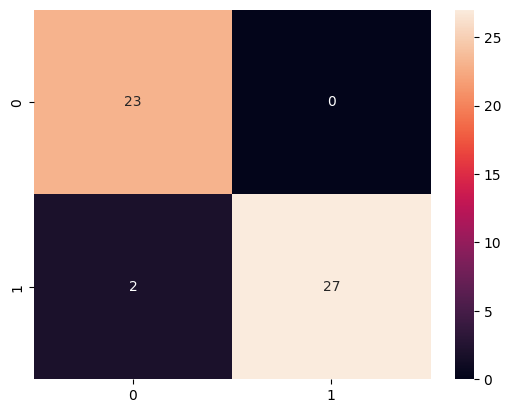

In [10]:
# evaluate on valid split
pred = clf.predict(X_val)
pred_prob = clf.predict_proba(X_val)[:, 1]

f1 = f1_score(y_val, pred)
acc_score = accuracy_score(y_val, pred)
auc_score = roc_auc_score(y_val, pred_prob)
cm = confusion_matrix(y_val, pred)

print(f"--- validation dataset ---")
print(f"f1: {f1}")
print(f"accuracy: {acc_score:0.4f}")
print(f"AUC: {auc_score:0.4f}")

sns.heatmap(cm, annot = True, fmt = 'd')

X_holdout.shape: (57, 30) | y_holdout.shape: (57,)
--- holdout dataset ---
f1: 0.9565217391304348
accuracy: 0.9649
AUC: 0.9949


<Axes: >

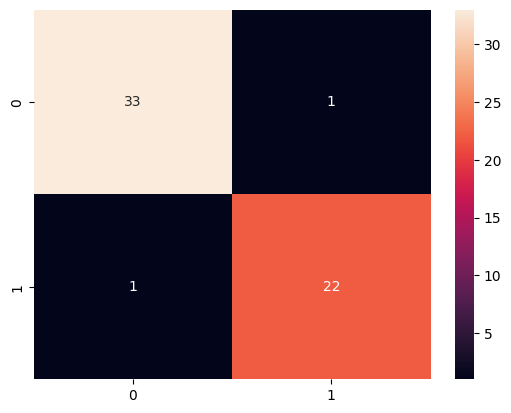

In [11]:
# evaluate on holdout set

X_holdout, y_holdout = holdout.drop("diagnosis", axis=1), holdout["diagnosis"]

print(f"X_holdout.shape: {X_holdout.shape} | y_holdout.shape: {y_holdout.shape}")

pred = clf.predict(X_holdout)
pred_prob = clf.predict_proba(X_holdout)[:, 1]

f1 = f1_score(y_holdout, pred)
acc_score = accuracy_score(y_holdout, pred)
auc_score = roc_auc_score(y_holdout, pred_prob)
cm = confusion_matrix(y_holdout, pred)

print(f"--- holdout dataset ---")
print(f"f1: {f1}")
print(f"accuracy: {acc_score:0.4f}")
print(f"AUC: {auc_score:0.4f}")

sns.heatmap(cm, annot = True, fmt = 'd')

### pca

In [16]:
# split using standardised data
X, y = train_norm.drop("diagnosis", axis=1), train_norm["diagnosis"]
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.3, random_state=66
)

print(f"X_tr.shape: {X_tr.shape} | y_tr.shape: {y_tr.shape}")
print(f"X_val.shape: {X_val.shape} | y_val.shape: {y_val.shape}")

X_tr.shape: (358, 30) | y_tr.shape: (358,)
X_val.shape: (154, 30) | y_val.shape: (154,)


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

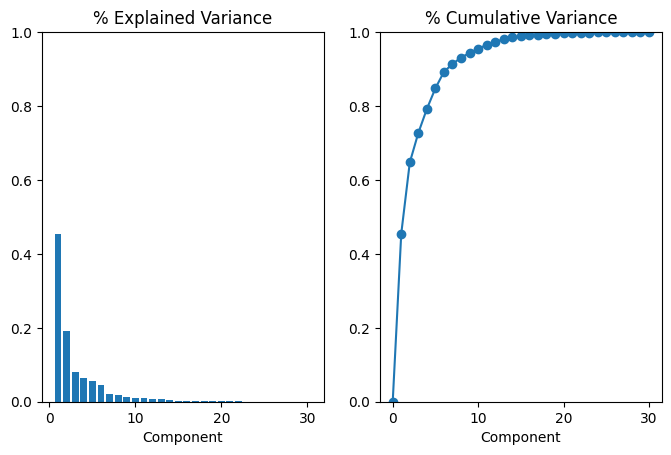

In [17]:
# fit pca
pca = PCA()
pca.fit(X_tr)

# visualise explained variance ratio to the number of components
plot_variance(pca, width=8, dpi=100)

In [18]:
pca = PCA(n_components = 4)
pca.fit(X_tr)

X_tr_pca = pca.transform(X_tr)
X_val_pca = pca.transform(X_val)

In [19]:
# train
# clf = make_pipeline(StandardScaler(), lgb.LGBMClassifier(n_estimators=100, max_depth=3))
clf = make_pipeline(StandardScaler(), RandomForestClassifier(random_state = 42))
clf.fit(X_tr_pca, y_tr)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

--- validation dataset ---
f1: 0.8636363636363636
accuracy: 0.8831
AUC: 0.9516


<Axes: >

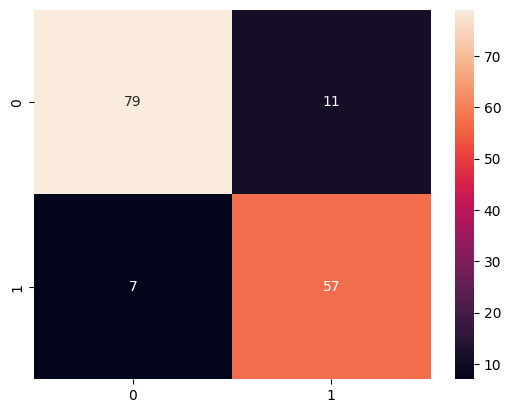

In [20]:
# evaluate on valid split
pred = clf.predict(X_val_pca)
pred_prob = clf.predict_proba(X_val_pca)[:, 1]

f1 = f1_score(y_val, pred)
acc_score = accuracy_score(y_val, pred)
auc_score = roc_auc_score(y_val, pred_prob)
cm = confusion_matrix(y_val, pred)

print(f"--- validation dataset ---")
print(f"f1: {f1}")
print(f"accuracy: {acc_score:0.4f}")
print(f"AUC: {auc_score:0.4f}")

sns.heatmap(cm, annot = True, fmt = 'd')

X_holdout_pca.shape: (57, 4) | y_holdout.shape: (57,)
--- holdout dataset ---
f1: 0.8936170212765957
accuracy: 0.9123
AUC: 0.9770


<Axes: >

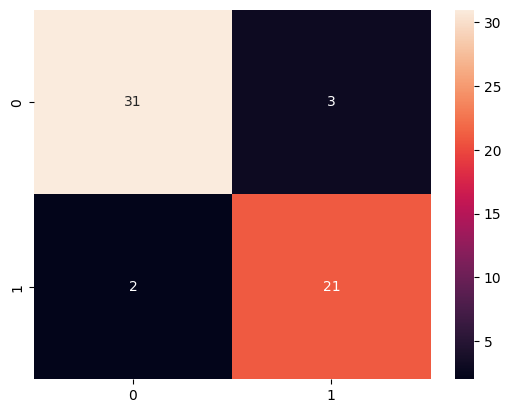

In [32]:
# evaluate on holdout set

X_holdout, y_holdout = holdout_norm.drop("diagnosis", axis=1), holdout_norm["diagnosis"]
X_holdout_pca = pca.transform(X_holdout)

print(f"X_holdout_pca.shape: {X_holdout_pca.shape} | y_holdout.shape: {y_holdout.shape}")

pred = clf.predict(X_holdout_pca)
pred_prob = clf.predict_proba(X_holdout_pca)[:, 1]

f1 = f1_score(y_holdout, pred)
acc_score = accuracy_score(y_holdout, pred)
auc_score = roc_auc_score(y_holdout, pred_prob)
cm = confusion_matrix(y_holdout, pred)

print(f"--- holdout dataset ---")
print(f"f1: {f1}")
print(f"accuracy: {acc_score:0.4f}")
print(f"AUC: {auc_score:0.4f}")

sns.heatmap(cm, annot = True, fmt = 'd')